## Imports and constants

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import diplib as dip
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

import itertools
import os
import astra

from __future__ import division
from imageio import get_writer, imread, imwrite
from sklearn.model_selection import train_test_split 
# from tifffile import imsave

np.random.seed(4)

DIPlib -- a quantitative image analysis library
Version 3.4.3 (Mar 21 2024)
For more information see https://diplib.org


2024-05-28 11:25:12.052760: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 11:25:12.117678: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 11:25:13.009213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Experiment parameters

In [2]:
input_dir = r"projections"
output_dir = r"projections"

space_shape = (128, 128, 128)
cube_shape = (64, 64, 64)

distance_source_origin = 44.14  # [mm]
distance_origin_detector = 69.80 - 44.14  # [mm]
detector_pixel_size = 1.05  # [mm]
detector_rows, detector_cols = 128, 128  # [pixels]

n_projections = 180
angles = np.linspace(0, 2 * np.pi, num=n_projections, endpoint=False)

# TODO: Generate training dataset

## Phantom creation

### Helper functions

In [3]:
def sphere(shape, radius, position):
    """Generate an n-dimensional spherical object."""

    assert len(position) == len(shape), "Position should be a position in as much dimensions as the shape"
    semisizes = (radius,) * len(shape)

    grid = [slice(-x0, dim - x0) for x0, dim in zip(position, shape)]
    position = np.ogrid[grid]

    arr = np.zeros(shape, dtype=float)
    for x_i, semisize in zip(position, semisizes):
        arr += (x_i / semisize) ** 2

    return arr <= 1.0

In [4]:
def get_plane_equation_from_points(p1, p2, p3): 
    """Calculate the parameters of the hyperplane formula based on three 3D points""" 
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    x3, y3, z3 = p3
    a1 = x2 - x1 
    b1 = y2 - y1 
    c1 = z2 - z1 
    a2 = x3 - x1 
    b2 = y3 - y1 
    c2 = z3 - z1 
    a = b1 * c2 - b2 * c1 
    b = a2 * c1 - a1 * c2 
    c = a1 * b2 - b1 * a2 
    d = (- a * x1 - b * y1 - c * z1) 
    return [a, b, c, d]

In [5]:
def plot_space(cube):
    """Plot the 3D Cube with the foreign object(s)"""
    colours = np.empty(cube.shape)
    voxelarray = (cube > 0) | (cube < 0)

    # TODO: Alter cube densities!
    colours = np.empty(voxelarray.shape, dtype=object)
    colours[cube < 0] = 'white'
    colours[cube > 0] = 'blue'
    colours[cube > 1] = 'red'

    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(cube.astype(float), facecolors=colours)
    plt.show()

### Cube and space definition

In [6]:
# Create the coordinate space
x, y, z = np.indices(space_shape)

# Create the bounds for the cube position
lower_bound = cube_shape[0] // 2
upper_bound = space_shape[0] - lower_bound

# Define the cube
cube = (x > lower_bound) & (x < upper_bound) & (y > lower_bound) \
    & (y < upper_bound) & (z > lower_bound) & (z < upper_bound)

### Cube cutoffs

In [7]:
# Get cube coordinates
cube_locations = np.where(cube)
cube_coords = [(cube_locations[0][i], cube_locations[1][i], cube_locations[2][i]) \
                for i in range(len(cube_locations[0]))]

# Calculate the line midpoint and the corner locations
line_midpoint = np.average(cube_locations)
cube_corners = list(itertools.product(*zip([lower_bound + 1, lower_bound + 1, lower_bound + 1], \
                                           [upper_bound - 1, upper_bound - 1, upper_bound - 1])))

# Cutoff for each corner
for corner in cube_corners:
    cutoff_size = np.random.choice(32, 3)
    corner_x, corner_y, corner_z = corner

    if corner_x < line_midpoint:
        x_point = [corner_x + cutoff_size[0], corner_y, corner_z]
    else:
        x_point = [corner_x - cutoff_size[0], corner_y, corner_z]
    if corner_y < line_midpoint:
        y_point = [corner_x, corner_y + cutoff_size[1], corner_z]
    else:
        y_point = [corner_x, corner_y - cutoff_size[1], corner_z]
    if corner_z < line_midpoint:
        z_point = [corner_x, corner_y, corner_z + cutoff_size[2]]
    else:
        z_point = [corner_x, corner_y, corner_z - cutoff_size[2]]

    # Calculate hyperplane formula parameters
    plane_params = get_plane_equation_from_points(x_point, y_point, z_point)
    
    # Calculate the side of the hyperplane that needs to be preserved
    sign = np.sign(np.dot(plane_params, np.array([*space_shape, 2])//2))
    
    # Remove all points on the wrong side of the hyperplane
    for x_coord, y_coord, z_coord in cube_coords:
        if np.sign(np.dot(plane_params, np.array([x_coord, y_coord, z_coord, 1]))) != sign:
            cube[x_coord][y_coord][z_coord] = False

### Foreign object insertion

In [8]:
# Randomly choose to add 1 or 2 foreign objects
n_objects = np.random.choice([1, 2], p=[.5, .5])

for _ in range(n_objects):
    # Randomly choose the size and location of the object
    radius = np.random.choice(list(range(3, 8)))
    cube_locations = np.where(cube)
    cube_coords = [(cube_locations[0][i], cube_locations[1][i], cube_locations[2][i]) \
                for i in range(len(cube_locations[0]))]

    random_center_idx = np.random.choice(len(cube_coords))
    object_center = cube_coords[random_center_idx]

    # Add a spherical foreign object of the chosen size at the chosen location
    foreign_object = sphere(space_shape, radius, object_center)
    cube = cube.astype(int) + foreign_object.astype(int) * 10

### Plot the space

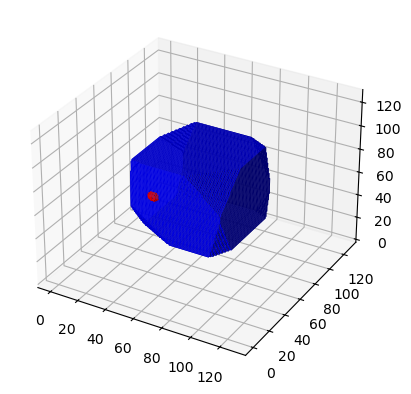

In [9]:
plot_space(cube)

# TODO: Create multiple phantoms
# TODO: Save the created phantoms

In [10]:
np.save("/data/s2902702/cito/foreign-object-workflow/phantom2.npy", cube)

## Sinogram generation (objects)

### Load phantom

In [3]:
# Create the volume geometry
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols, detector_rows)

# Load in the phantom
phantom = np.load("/data/s2902702/cito/foreign-object-workflow/phantom2.npy")

# Combine phantom and volume geometry into a data object
phantom_id = astra.data3d.create('-vol', vol_geom, data=phantom)

### Create projections

> Indexed in slices where slice 0 is the top of the object

In [4]:
proj_geom = astra.create_proj_geom(
        'cone',
        1,
        1,
        detector_rows,
        detector_cols,
        angles,
        (distance_source_origin + distance_origin_detector) / detector_pixel_size,
        0
)

# TODO: GPU!
projections_id, projections = astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)

### Add poisson noise to projections

In [5]:
if False:
    m = projections
    m[m < 0] = 0
    projections += np.random.poisson(m)

### Save projections and cleanup

In [6]:
# Write projections to the output directory
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)
for i in range(n_projections):
    projection = projections[:, i, :]
    with get_writer(os.path.join(output_dir, 'proj%04d.tif' %i)) as writer:
        writer.append_data(projection)

# TODO: Generalize for multiple objects
 
# Cleanup
# TODO: Might not be needed for multiple objects
astra.data3d.delete(projections_id)
astra.data3d.delete(phantom_id)

## Object reconstruction

### Load projections

In [7]:
projections = np.zeros((detector_rows, n_projections, detector_cols))
for i in range(n_projections):
    im = imread(os.path.join(input_dir, 'proj%04d.tif' % i)).astype(float)
    im /= 65535  # NOTE: uint16
    projections[:, i, :] = im

/tmp/ipykernel_44888/842563508.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imread(os.path.join(input_dir, 'proj%04d.tif' % i)).astype(float)


### Load projections in astra

In [8]:
proj_geom = astra.create_proj_geom(
    'cone',
    1,
    1,
    detector_rows,
    detector_cols,
    angles,
    (distance_source_origin + distance_origin_detector) / detector_pixel_size,
    0
)
projections_id = astra.data3d.create('-sino', proj_geom, projections)

### Reconstruct objects

In [9]:
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols, detector_rows)
reconstruction_id = astra.data3d.create('-vol', vol_geom, data=0)

# TODO: Alter algorithm options workflow
# TODO: Use SIRT? (SIRT3D_CUDA)
algorithm_options = [
    "FDK_CUDA",
    "SIRT3D_CUDA"
]

for algorithm in algorithm_options:
    alg_cfg = astra.astra_dict(algorithm)
    alg_cfg['ProjectionDataId'] = projections_id
    alg_cfg['ReconstructionDataId'] = reconstruction_id

    if algorithm == "FDK_CUDA":
        output_dir = "FDK"
        alg_cfg["ShortScan"] = True
    elif algorithm == "SIRT3D_CUDA":
        output_dir = "SIRT"

    algorithm_id = astra.algorithm.create(alg_cfg)
    astra.algorithm.run(algorithm_id)
    reconstruction = astra.data3d.get(reconstruction_id)
    
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i in range(detector_rows):
        im = reconstruction[i, :, :]
        im = np.flipud(im)
        imwrite(os.path.join(output_dir, 'reco%04d.tiff' % i), im)

### Cleanup

In [10]:
astra.algorithm.delete(algorithm_id)
astra.data3d.delete(reconstruction_id)
astra.data3d.delete(projections_id)

## Foreign object segmentation

In [11]:
# For each of the 128 layers in the reconstruction
ground_truth = np.zeros(reconstruction.shape).astype(bool)
for z in range(len(reconstruction[:, 0, :])):
    # Do segmentation of the foreign object.
    img = reconstruction[:, z, :] * 10  # TODO
    img = dip.Image(img)
    segmented = 0.005 > img > 0.001  # TODO: Check for multiple phantoms
    # Set the foreign object to 1 and the others to 0.
    ground_truth[:, z, :] = segmented
np.where(ground_truth)

(array([34, 35, 35, ..., 66, 67, 67]),
 array([ 45,  42,  42, ..., 114,   1, 110]),
 array([ 88,  87,  88, ..., 115,  98, 121]))

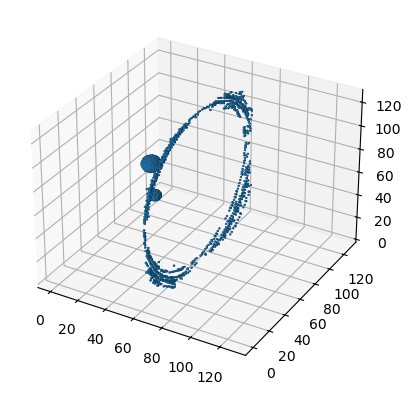

In [13]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(ground_truth.astype(int))
plt.show()

## Sinogram generation (targets)

In [12]:
# Create the volume geometry
vol_geom = astra.creators.create_vol_geom(detector_cols, detector_cols, detector_rows)

# Combine phantom and volume geometry into a data object
phantom_id = astra.data3d.create('-vol', vol_geom, data=ground_truth)

proj_geom = astra.create_proj_geom(
        'cone',
        1,
        1,
        detector_rows,
        detector_cols,
        angles,
        (distance_source_origin + distance_origin_detector) / detector_pixel_size,
        0
)

# TODO: GPU!
projections_id, projections = astra.creators.create_sino3d_gpu(phantom_id, proj_geom, vol_geom)

## Training set creation

In [13]:
# Create training set
x_train = list()
y_train = list()
for i in range(n_projections):
    obj = imread(os.path.join(input_dir, 'proj%04d.tif' % i)).astype(float)
    obj /= 65535  # NOTE: uint16
    x_train.append(obj)
    target = dip.Image(projections[:, i, :])
    target = dip.IsodataThreshold(target)
    y_train.append(np.asarray(target))

X, y = list(), list()
for idx, img in enumerate(x_train):
    img_max = np.max(img)
    img_min = np.min(img)
    X.append((img - img_min) / (img_max - img_min))
    y.append(y_train[idx].astype(int))

/tmp/ipykernel_44888/4292678395.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  obj = imread(os.path.join(input_dir, 'proj%04d.tif' % i)).astype(float)


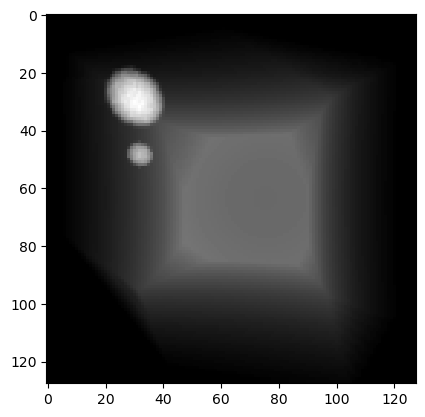

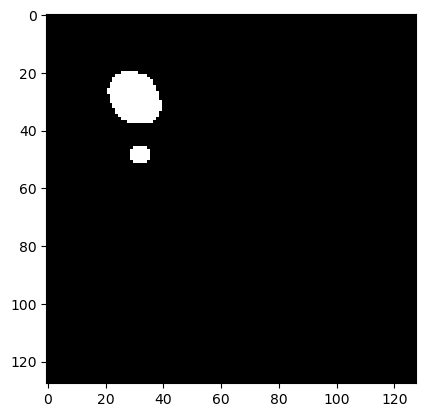

In [14]:
dip.Image(x_train[50]).Show()
dip.Image(y_train[50]).Show()  # TODO: Segmentation of image 100!

## Network training

### Initialize [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28)

[For noobs](https://www.geeksforgeeks.org/u-net-architecture-explained/)

[More explanation, which I need](https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406)

[Code!](https://github.com/VidushiBhatia/U-Net-Implementation/blob/main/U_Net_for_Image_Segmentation_From_Scratch_Using_TensorFlow_v4.ipynb)

In [15]:
# X: #img (180), img_height (128), img_width (128), img_channels (1 \in [0.0, 1.0])
# y: #targets (180), img_height (128), img_width (128), img_classes (1 \in {0, 1})

In [16]:
def encoder_block(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    conv = tf.keras.layers.Conv2D(
          n_filters,
          3,
          activation = 'relu',
          padding = 'same',
          kernel_initializer = 'HeNormal'
    )(inputs)
    
    conv = tf.keras.layers.Conv2D(
          n_filters,
          3,
          activation = 'relu',
          padding = 'same',
          kernel_initializer = 'HeNormal'
    )(inputs)

    conv = tf.keras.layers.BatchNormalization()(conv, training=False)

    if dropout_prob > 0:     
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)    
    else:
        next_layer = conv

    skip_connection = conv

    return next_layer, skip_connection

In [17]:
def decoder_block(prev_layer_input, skip_layer_input, n_filters=32):
    up = tf.keras.layers.Conv2DTranspose(
            n_filters,
            (3, 3),
            strides = (2, 2),
            padding = 'same'
    )(prev_layer_input)
    
    merge = tf.keras.layers.concatenate([up, skip_layer_input], axis=3)
    
    conv = tf.keras.layers.Conv2D(
          n_filters,
          3,
          activation = 'relu',
          padding = 'same',
          kernel_initializer = 'HeNormal'
    )(merge)
    
    conv = tf.keras.layers.Conv2D(
          n_filters,
          3,
          activation = 'relu',
          padding = 'same',
          kernel_initializer = 'HeNormal'
    )(conv)
    
    return conv

In [18]:
def build_unet(input_size=(128, 128, 3), n_filters=32, n_classes=3):

    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = encoder_block(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = encoder_block(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = encoder_block(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = encoder_block(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = encoder_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    
    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = decoder_block(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = decoder_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = decoder_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = decoder_block(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = tf.keras.layers.Conv2D(
            n_filters,
            3,
            activation = 'relu',
            padding = 'same',
            kernel_initializer = 'he_normal'
    )(ublock9)

    conv10 = tf.keras.layers.Conv2D(n_classes, 1, padding='same')(conv9)
    
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

### Train network

(128, 128)
(128, 128)


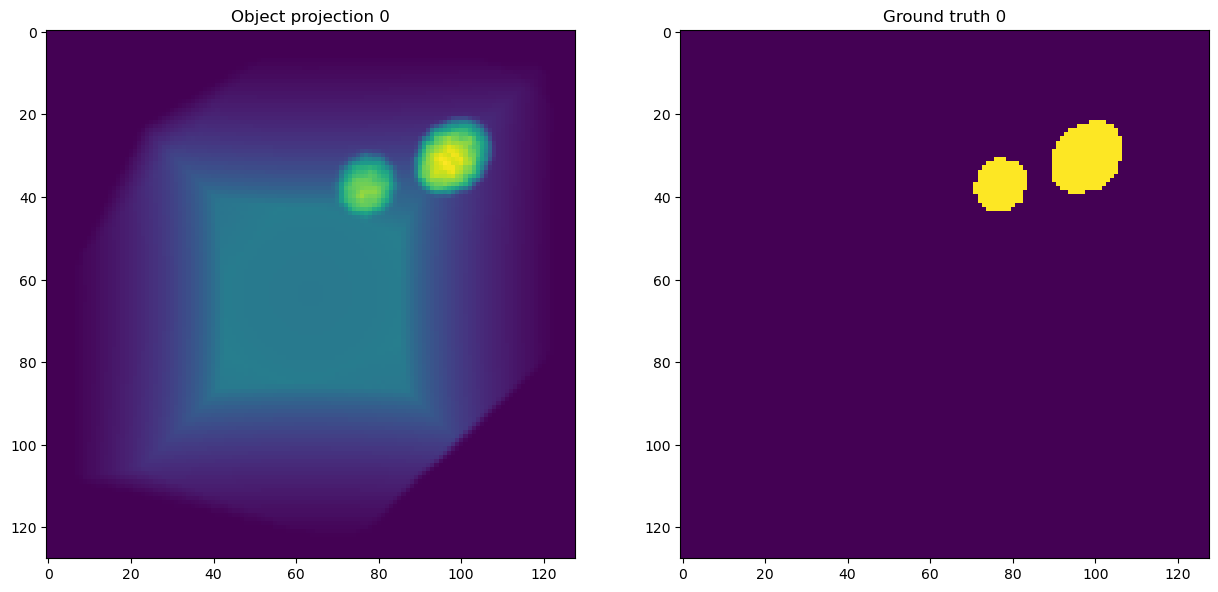

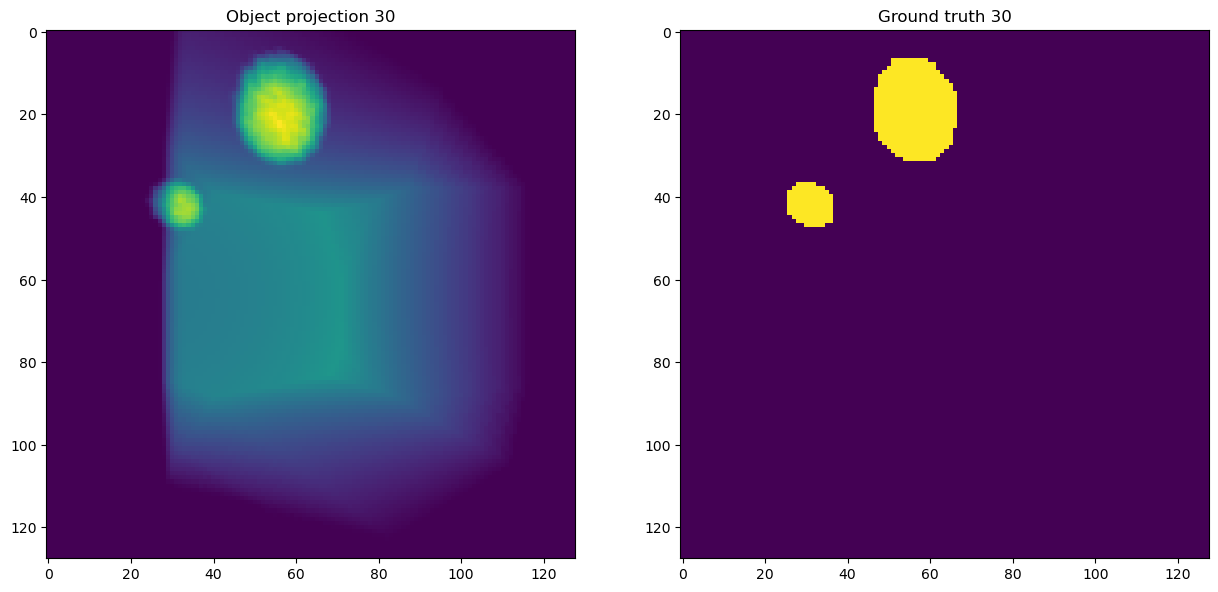

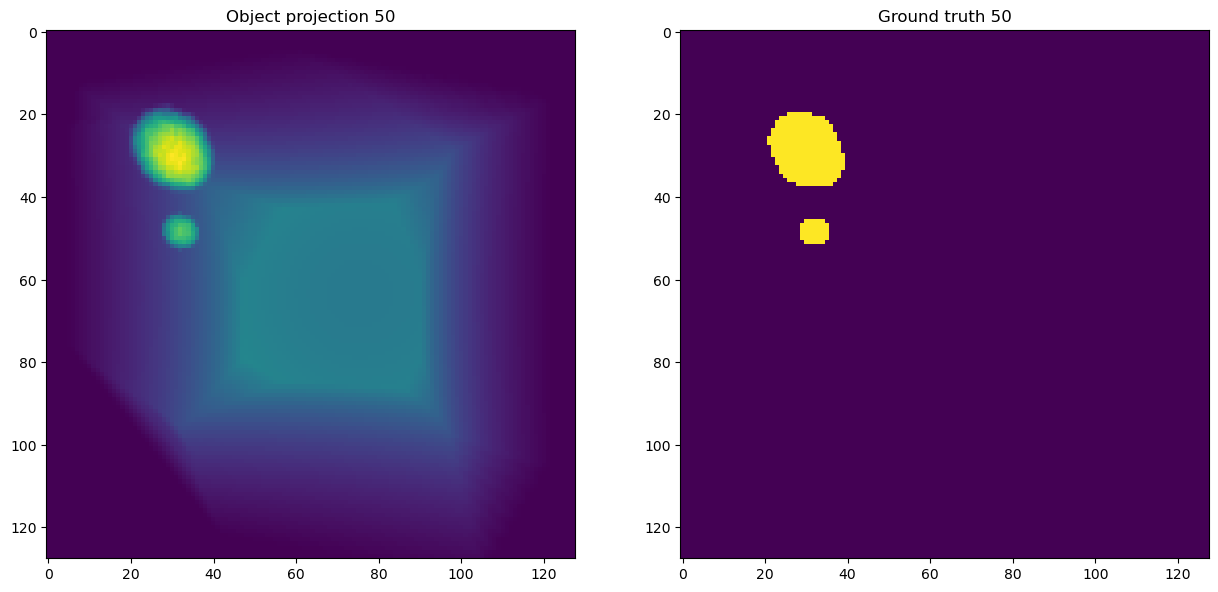

In [18]:
show_images = [0, 30, 50]
print(X[0].shape)
print(y[0].shape)
for i in show_images:
    img_view  = X[i]
    mask_view = y[i]
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Object projection '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Ground truth '+ str(i))

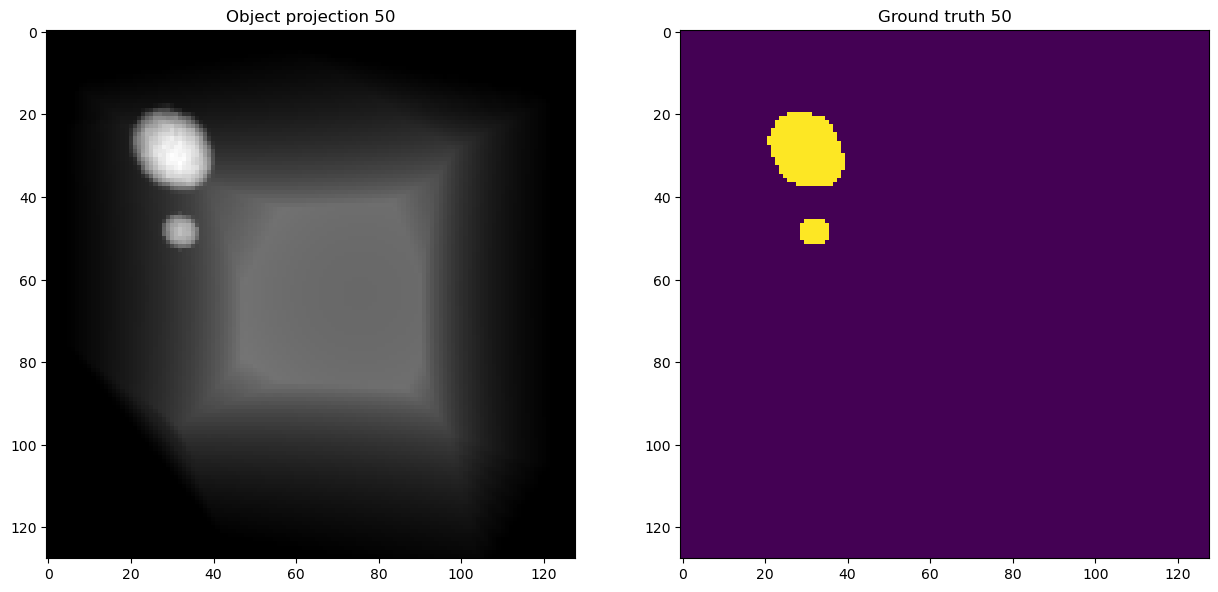

In [19]:
# Change X to include images with three dimensions
# new_X = np.zeros((*np.array(X).shape, 3))
# for img in X:
#     for i in range(len(img)):
#         for j in range(i):
#             new_X[i, j] = np.array([img[i, j]]*3)

new_X = list()
new_y = np.array(y)
for img in X:
    new_X.append(np.asarray(dip.ColorSpaceManager.Convert(dip.Image(img), 'RGB')))


X_train, X_validate, y_train, y_validate = train_test_split(new_X, new_y, test_size=0.2, random_state=4)

for i in [50]:
    img_view  = new_X[i]
    mask_view = new_y[i]
    fig, arr = plt.subplots(1, 2, figsize=(15, 15))
    arr[0].imshow(img_view)
    arr[0].set_title('Object projection '+ str(i))
    arr[1].imshow(mask_view)
    arr[1].set_title('Ground truth '+ str(i))

In [20]:
unet = build_unet(input_size=(128,128,3), n_filters=32, n_classes=2)
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 256) │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 512) │  1,180,160 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 512) │      2,048 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 8, 512) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,500,098 (20.98 MB)

 Trainable params: 5,498,114 (20.97 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [21]:
unet.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics = ['accuracy']
)

In [34]:
np.array(X_train).shape, np.array(y_train).shape

X_train = np.array(X_train).reshape((144, 128, 128, 3))
y_train = np.array(y_train).reshape((144, 128, 128, 1))
X_validate = np.array(X_validate).reshape((36, 128, 128, 3))
y_validate = np.array(y_validate).reshape((36, 128, 128, 1))

In [35]:
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data = (X_validate, y_validate))

Epoch 1/20


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8576 - loss: 0.3779

W0000 00:00:1716910642.729665   46330 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1716910643.538011   46330 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8595 - loss: 0.3749 - val_accuracy: 0.9120 - val_loss: 0.4209
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8717 - loss: 0.4008 - val_accuracy: 0.9161 - val_loss: 0.5719
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8587 - loss: 0.3645 - val_accuracy: 0.9096 - val_loss: 0.4402
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8743 - loss: 0.3236 - val_accuracy: 0.9092 - val_loss: 0.4714
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8763 - loss: 0.2971 - val_accuracy: 0.9092 - val_loss: 0.7038
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8761 - loss: 0.2857 - val_accuracy: 0.9092 - val_loss: 0.8228
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8874 - loss: 0.2593 - val_accuracy: 0.9098 - val_loss: 0.5992
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8919 - loss: 0.2573 - val_accuracy: 0.9092 - val_loss: 0.9500
Epoch 9/20
5/5 ━━━━

In [36]:
unet.save('unet_1.keras')

In [37]:
new_model = tf.keras.models.load_model('unet_1.keras')

## Network evaluation

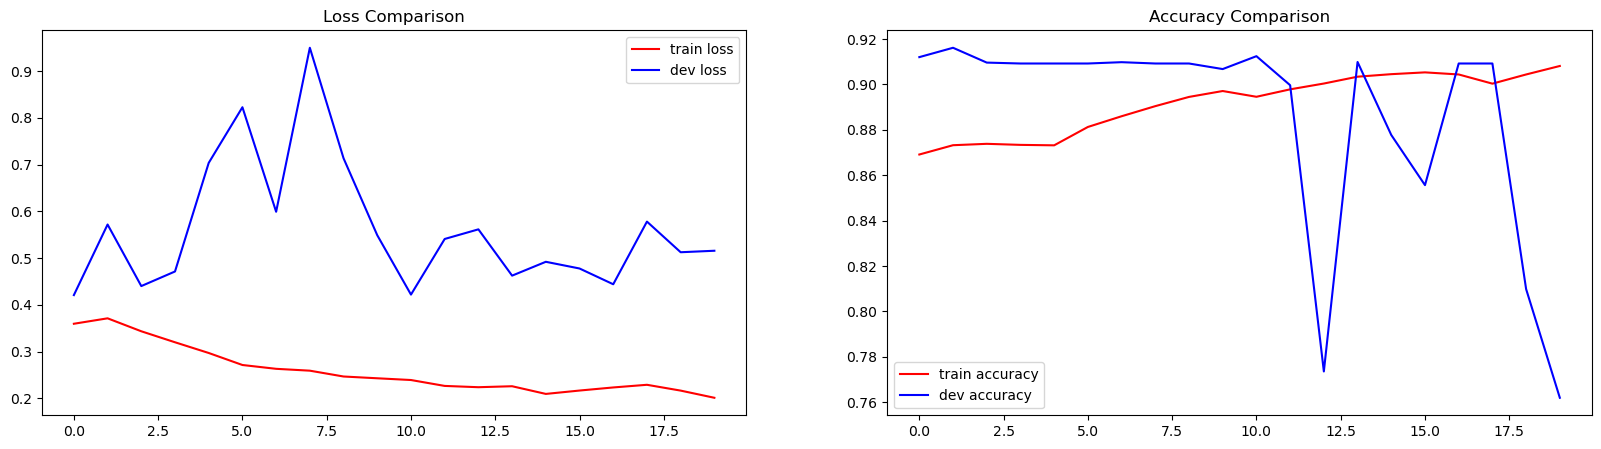

In [38]:
# Evaluate deep learning segmentation network
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step


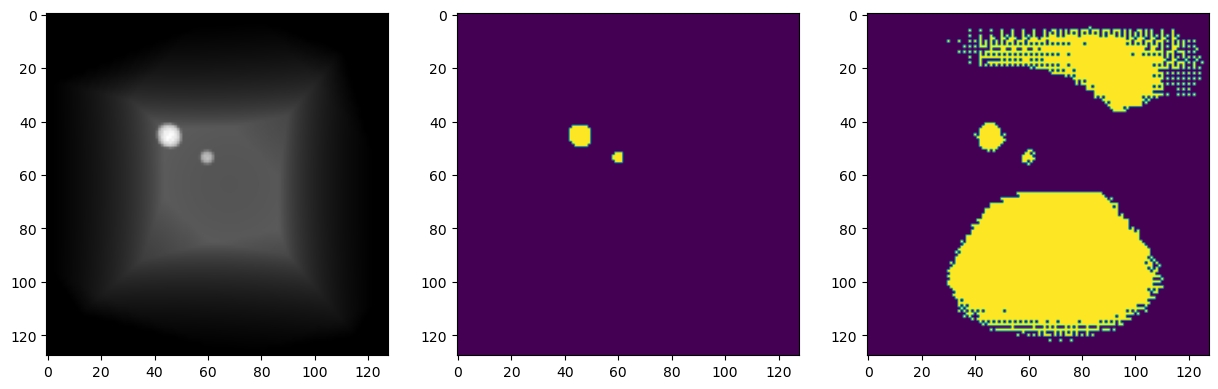

In [71]:
# TODO
# new_model.evaluate(X_validate, y_validate)


# Add any index to contrast the predicted mask with actual mask
# index = 20
# # VisualizeResults(index)

idx = 21

img = X_validate[idx]
target = y_validate[idx]
predicted = new_model.predict(X_validate)[idx]
prediction = np.zeros((128, 128, 1))

for x in range(128):
    for y in range(128):
        prediction[x][y] = np.argmax(predicted[x][y])

fig, arr = plt.subplots(1, 3, figsize=(15,15))
arr[0].imshow(img)
arr[1].imshow(target)
arr[2].imshow(prediction)

# TODO: Remove artefacts in 3D segmentation step!